# R: A/B Testing with DoubleML

<img src="figures/ab_testing.jpg" alt="An illustration of A/B testing." style="width: 400px;"/>

Image Source Freepik http://www.freepik.com, Designed by macrovector


In [14]:
# Load required packages for this tutorial
library(DoubleML)
library(mlr3)
library(mlr3learners)
library(data.table)
library(ggplot2)

# suppress messages during fitting
lgr::get_logger("mlr3")$set_threshold("warn")


Warning message:
"package 'data.table' was built under R version 3.6.3"


In [15]:
library(data.table)

# Load data set from url (internet connection required)
url = "https://raw.githubusercontent.com/DoubleML/doubleml-docs/p-add-ACIC-dataset/doc/examples/data/high42.CSV"
df = fread(url)

dim(df)

# TODO: Add info on types of variables
str(df)

[1] 1000  202

Classes 'data.table' and 'data.frame':	1000 obs. of  202 variables:
 $ Y   : num  7.36 8.33 7.47 6.5 7.04 ...
 $ A   : int  1 1 0 1 1 0 0 1 0 0 ...
 $ V1  : int  10 12 14 0 12 8 10 9 11 15 ...
 $ V2  : int  0 0 1 1 0 0 1 1 0 1 ...
 $ V3  : int  0 1 1 0 0 1 1 1 1 1 ...
 $ V4  : int  7 4 2 9 9 6 6 6 11 7 ...
 $ V5  : num  193 200 194 202 201 ...
 $ V6  : num  23.7 19.3 24.6 25.5 31.2 ...
 $ V7  : int  8 7 5 4 6 9 2 4 7 2 ...
 $ V8  : num  0.185 0.515 0.309 0.16 0.292 ...
 $ V9  : num  15.85 9.24 10.79 22.64 25.79 ...
 $ V10 : int  6 5 4 8 3 6 5 4 9 4 ...
 $ V11 : int  1 0 1 0 1 1 1 1 1 1 ...
 $ V12 : int  0 0 0 1 1 0 1 0 0 1 ...
 $ V13 : num  0.201 0.223 0.175 0.149 0.138 ...
 $ V14 : num  1.17 -1.537 -1.285 0.348 0.345 ...
 $ V15 : num  1.22 1.12 1.27 1.14 1.3 ...
 $ V16 : num  -16.8 -15.1 -27.8 -15.8 -30.3 ...
 $ V17 : num  8.07 4.48 6.19 4.75 7.79 ...
 $ V18 : int  1 0 1 0 0 0 1 0 0 1 ...
 $ V19 : num  1.04 -0.542 1.021 1.227 1.655 ...
 $ V20 : int  30 -1 59 25 8 25 -1 -9 43 41 ...
 $

In [3]:
head(df)

Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200
<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,...,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>
7.358185,1,10,0,0,7,192.7938,23.67695,8,0.18544294,...,1.462837,1,1627.274,0,0,4.683956,0.5656669,0,3,0.02433804
8.333672,1,12,0,1,4,199.6536,19.28127,7,0.51484172,...,1.330522,1,1661.484,1,0,6.766661,-0.3954021,0,4,0.05651780
7.472758,0,14,1,1,2,194.2078,24.58933,5,0.30919878,...,1.384151,1,1658.939,0,0,5.647794,1.1127661,0,0,0.01344207
6.502319,1,0,1,0,9,201.8380,25.51392,4,0.16016010,...,1.220303,1,1650.802,0,0,5.370363,-0.3058420,0,4,0.03463235
7.043758,1,12,0,0,9,201.3604,31.16064,6,0.29197555,...,1.170094,1,1676.819,0,0,3.446532,2.4406606,0,1,0.01751381
5.658337,0,8,0,1,6,193.2195,20.46564,9,0.05673076,...,1.802945,1,1634.093,1,0,5.294410,1.0869714,1,0,0.04712806


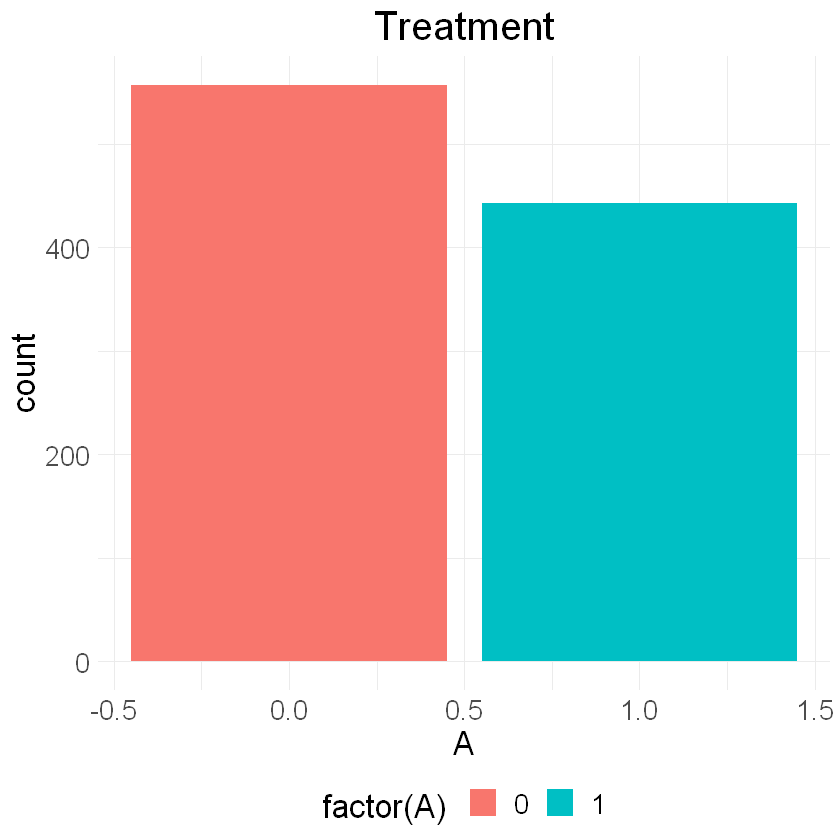

In [6]:
hist_A = ggplot(df, aes(x = A, fill = factor(A))) +
            geom_bar() + theme_minimal() +
            ggtitle("Treatment") + xlab("A") +
            theme(legend.position = "bottom", plot.title = element_text(hjust = 0.5),
                  text = element_text(size = 20))
hist_A

In [16]:
# Unconditional ATE
df[, mean(Y), by = A]

ATE_uncond = df[A == 1, mean(Y)] - df[A==0, mean(Y)]
ATE_uncond

A,V1
<int>,<dbl>
1,7.953744
0,6.836141


[1] 1.117603

### `DoubleMLData`


In [24]:
features_base = colnames(df)[grep("V", colnames(df))]
data_dml = DoubleMLData$new(df,
                           y_col = "Y",
                           d_cols = "A",
                           x_cols = features_base)

In [25]:
print(data_dml)

================= DoubleMLData Object ==================


------------------ Data summary      ------------------
Outcome variable: Y
Treatment variable(s): A
Covariates: V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, V29, V30, V31, V32, V33, V34, V35, V36, V37, V38, V39, V40, V41, V42, V43, V44, V45, V46, V47, V48, V49, V50, V51, V52, V53, V54, V55, V56, V57, V58, V59, V60, V61, V62, V63, V64, V65, V66, V67, V68, V69, V70, V71, V72, V73, V74, V75, V76, V77, V78, V79, V80, V81, V82, V83, V84, V85, V86, V87, V88, V89, V90, V91, V92, V93, V94, V95, V96, V97, V98, V99, V100, V101, V102, V103, V104, V105, V106, V107, V108, V109, V110, V111, V112, V113, V114, V115, V116, V117, V118, V119, V120, V121, V122, V123, V124, V125, V126, V127, V128, V129, V130, V131, V132, V133, V134, V135, V136, V137, V138, V139, V140, V141, V142, V143, V144, V145, V146, V147, V148, V149, V150, V151, V152, V153, V154, V155, V156, 

### IRM


In [26]:
# TODO: helper function for prediction of nuisance

pred_acc_irm = function() {
    
}

### Benchmark: Model based on Linear and Logistic Regression

In [17]:
linreg = lrn("regr.lm")
logreg_class = lrn("classif.log_reg")

set.seed(1234)
dml_irm_regression = DoubleMLIRM$new(data_dml,
                                    ml_g = linreg,
                                    ml_m = logreg_class,
                                    trimming_threshold = 0.025,
                                    n_folds = 3,
                                    n_rep = 3)

dml_irm_regression$fit(store_predictions = TRUE)
dml_irm_regression$summary()

ERROR: Error in sort(assert_subset(properties, mlr_reflections$learner_properties[[task_type]])): Assertion on 'properties' failed: Must be a subset of {'featureless','missings','weights','importance','selected_features','oob_error'}, but is {'weights','loglik'}.


In [ ]:
# TODO: Calculate Bias
# TODO: Summary for predictive accuracy
# TODO: Print RMSE mean and sd for ml_g and log_loss for ml_m

### Double Machine Learning based on Lasso


In [18]:
lasso = lrn("regr.cv_glmnet", nfolds = 5, s = "lambda.min")
lasso_class = lrn("classif.cv_glmnet", nfolds = 5, s = "lambda.min")

set.seed(1234)
dml_irm_lasso = DoubleMLIRM$new(data_dml,
                               ml_g = lasso,
                               ml_m = lasso_class,
                               trimming_threshold = 0.025,
                               n_folds = 3,
                               n_rep = 3)

dml_irm_lasso$fit(store_predictions = TRUE)

dml_irm_lasso$summary()

ERROR: Error in checkClass(x, classes, ordered, null.ok): Objekt 'data_dml' nicht gefunden


In [19]:
# TODO: Calculate Bias
# TODO: Summary for predictive accuracy
# TODO: Print RMSE mean and sd for ml_g and log_loss for ml_m

### Double Machine Learning based on Random Forest


In [20]:
randomForest = lrn("regr.ranger")
randomForest_class = lrn("classif.ranger")

set.seed(1234)
dml_irm_forest = DoubleMLIRM$new(data_dml,
                                ml_g = randomForest,
                                ml_m = randomForest_class,
                                trimming_threshold = 0.025,
                                n_folds = 3,
                                n_rep = 3)

# Set nuisance-part specific parameters
dml_irm_forest$set_ml_nuisance_params("ml_g0", "A",
                                      list("mtry" = 200,
                                           "num.trees" = 250))
dml_irm_forest$set_ml_nuisance_params("ml_g1", "A",
                                      list("mtry" = 200,
                                           "num.trees" = 250))
dml_irm_forest$set_ml_nuisance_params("ml_m", "A",
                                      list("mtry" = 200,
                                           "num.trees" = 250))

dml_irm_forest$fit(store_predictions = TRUE)
dml_irm_forest$summary()

ERROR: Error in checkClass(x, classes, ordered, null.ok): Objekt 'data_dml' nicht gefunden


In [ ]:
# TODO: Calculate Bias
# TODO: Summary for predictive accuracy
# TODO: Print RMSE mean and sd for ml_g and log_loss for ml_m

### Double Machine Learning based on Extreme Gradient Boosting

In [ ]:
boost = lrn("regr.xgboost",
            objective = "reg:squarederror")
boost_class = lrn("classif.xgboost",
                  objective = "binary:logistic",
                  eval_metric = "logloss")

set.seed(1234)
dml_irm_boost = DoubleMLIRM$new(data_dml,
                               ml_g = boost,
                               ml_m = boost_class,
                               trimming_threshold = 0.025,
                               n_folds = 3,
                               n_rep = 3)

dml_irm_boost$set_ml_nuisance_params("ml_g0", "A",
                                     list("nrounds" = 30,
                                          "eta" = 0.2))
dml_irm_boost$set_ml_nuisance_params("ml_g1", "A",
                                     list("nrounds" = 30,
                                          "eta" = 0.2))
dml_irm_boost$set_ml_nuisance_params("ml_m", "A",
                                      list("nrounds" = 15,
                                           "eta" = 0.2))

dml_irm_boost$fit(store_predictions = TRUE)
dml_irm_boost$summary()

In [ ]:
# TODO: Calculate Bias
# TODO: Summary for predictive accuracy
# TODO: Print RMSE mean and sd for ml_g and log_loss for ml_m

#### IRM - Summary of coefficient estimates



In [21]:
# TODO: Add summary of results

In [ ]:
# TODO: Add visualization of summary

#### IRM - Summary of prediction assessment metric's mean values

In [23]:
# TODO: Add comparison/summary for predictive accuracy (nuisance)

In [24]:
# TODO: Add visualization of summary

### Inspection of the benchmark model


In [ ]:
# TODO: Function for propensity score visualiztation

rep_propscore_plot = function() {
    
}

## 2. Partially Linear Regression Model (PLR)


In [ ]:
# TODO: Function for calculation of prediction accuracy PLR

pred_acc_plr = function() {
    
}

### Benchmark: Model based on Linear and Logistic Regression

In [ ]:
linreg = lrn("regr.lm")
logreg_class = lrn("classif.log_reg")

set.seed(1234)
dml_plr_regression = DoubleMLPLR$new(data_dml,
                                    ml_g = linreg,
                                    ml_m = logreg_class,
                                    trimming_threshold = 0.025,
                                    n_folds = 3,
                                    n_rep = 3)

dml_plr_regression$fit(store_predictions = TRUE)
dml_plr_regression$summary()

In [ ]:
# TODO: Calculate Bias
# TODO: Summary for predictive accuracy
# TODO: Print RMSE mean and sd for ml_g and log_loss for ml_m

### Double Machine Learning based on Lasso

In [25]:
lasso = lrn("regr.cv_glmnet", nfolds = 5, s = "lambda.min")
lasso_class = lrn("classif.cv_glmnet", nfolds = 5, s = "lambda.min")

set.seed(1234)
dml_plr_lasso = DoubleMLPLR$new(data_dml,
                               ml_g = lasso,
                               ml_m = lasso_class,
                               n_folds = 3,
                               n_rep = 3)

dml_plr_lasso$fit(store_predictions = TRUE)

dml_plr_lasso$summary()


ERROR: Error in checkClass(x, classes, ordered, null.ok): Objekt 'data_dml' nicht gefunden


In [ ]:
# TODO: Calculate Bias
# TODO: Summary for predictive accuracy
# TODO: Print RMSE mean and sd for ml_g and log_loss for ml_m

### Double Machine Learning based on Random Forests

In [ ]:
randomForest = lrn("regr.ranger")
randomForest_class = lrn("classif.ranger")

set.seed(1234)
dml_plr_forest = DoubleMLPLR$new(data_dml,
                                ml_g = randomForest,
                                ml_m = randomForest_class,
                                n_folds = 3,
                                n_rep = 3)


dml_plr_forest$fit(store_predictions = TRUE)
dml_plr_forest$summary()

In [26]:
# TODO: Calculate Bias
# TODO: Summary for predictive accuracy
# TODO: Print RMSE mean and sd for ml_g and log_loss for ml_m

### Double Machine Learning based on Extreme Gradient Boosting

In [ ]:
boost = lrn("regr.xgboost",
            objective = "reg:squarederror",
            eta = 0.1, nrounds = 57, max_depth = 2)

boost_class = lrn("classif.xgboost",
                  objective = "binary:logistic",
                  eval_metric = "logloss",
                  eta = 0.1, nrounds = 10, max_depth = 3)

set.seed(1234)
dml_plr_boost = DoubleMLPLR$new(data_dml,
                               ml_g = boost,
                               ml_m = boost_class,
                               n_folds = 3,
                               n_rep = 3)

dml_plr_boost$fit(store_predictions = TRUE)
dml_plr_boost$summary()

In [ ]:
# TODO: Calculate Bias
# TODO: Summary for predictive accuracy
# TODO: Print RMSE mean and sd for ml_g and log_loss for ml_m

#### PLR - Summary of coefficient estimates

In [ ]:
# TODO: Summary